In [1]:
sc

<SparkContext master=local[*] appName=PySparkShell>

## Take a look at data (5.2)

In [103]:
from pymongo import MongoClient
import pprint

In [100]:
client=MongoClient('localhost')

In [101]:
db=client.packt

In [102]:
redditCollection=db.reddit

In [104]:
pprint.pprint(redditCollection.find_one())

{u'_id': ObjectId('5a27f91968452953eb55cf19'),
 u'archived': True,
 u'author': u'[deleted]',
 u'author_flair_css_class': None,
 u'author_flair_text': None,
 u'body': u'[deleted]',
 u'controversiality': 0,
 u'created_utc': u'1262304001',
 u'distinguished': None,
 u'downs': 0,
 u'edited': False,
 u'gilded': 0,
 u'id': u'c0i12v6',
 u'link_id': u't3_ak0b7',
 u'name': u't1_c0i12v6',
 u'parent_id': u't3_ak0b7',
 u'retrieved_on': 1426171563,
 u'score': 2,
 u'score_hidden': False,
 u'subreddit': u'trees',
 u'subreddit_id': u't5_2r9vp',
 u'ups': 2}


## Specify schema

In [3]:
import pyspark.sql.types

In [134]:
from pyspark.sql.types import StructField,StructType, FloatType,StringType,IntegerType

In [106]:
schema=StructType([
                StructField('score',IntegerType()),
                   StructField('created_utc',StringType()),
                  StructField('postLength',IntegerType())])

## Read Mongo collection into Dataframe

In [107]:
pipeline = "[\
{$project:{'score':1,'created_utc':1,'_id':0,'postLength':{$size:{$split:['$body',' ']}}}}]"

In [109]:
df = spark.read.format("com.mongodb.spark.sql.DefaultSource").option("uri",
"mongodb://127.0.0.1/packt.reddit").option("pipeline",pipeline).schema(schema).load()

In [110]:
%time df.count()

CPU times: user 0 ns, sys: 8 ms, total: 8 ms
Wall time: 19.8 s


2884096

In [111]:
df.printSchema()

root
 |-- score: integer (nullable = true)
 |-- created_utc: string (nullable = true)
 |-- postLength: integer (nullable = true)



## Convert UTC timestamp to hour

In [112]:
from pyspark.sql.functions import udf
import datetime

In [113]:
getHour=udf(lambda x:datetime.datetime.fromtimestamp(int(x)).hour,IntegerType())

In [114]:
dfClean=df.withColumn('hour',getHour('created_utc'))

In [115]:
%time dfCleanPd=dfClean.toPandas()
# Convert to pandas dataframe for easy plotting

CPU times: user 21.2 s, sys: 360 ms, total: 21.6 s
Wall time: 1min 1s


In [116]:
dfCleanPd.shape

(2884096, 4)

## Look at distribution over hour of day

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

In [117]:
gg=dfCleanPd.groupby('hour')

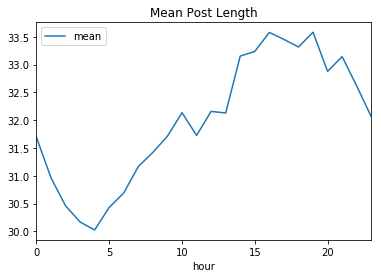

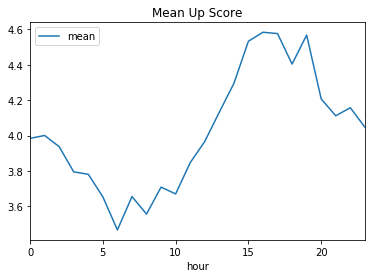

In [118]:
gg.agg(['mean'])['postLength'].plot()
plt.title('Mean Post Length')
gg.agg(['mean'])['ups'].plot()
plt.title('Mean Up Score')

## Preparing data for spark.ml (5.3)

In [137]:
from pyspark.ml.feature import VectorAssembler
# We need to convert DataFrame columns into Vectors

In [121]:
dfClean.head()

Row(score=2, created_utc=u'1262304001', postLength=1, hour=0)

In [124]:
assembler=VectorAssembler(
  inputCols=["postLength","hour"], outputCol="features")

In [125]:
vectorDf=assembler.transform(dfClean)

In [126]:
vectorDf.head()

Row(score=2, created_utc=u'1262304001', postLength=1, hour=0, features=DenseVector([1.0]))

## Predicting up votes (5.4)

In [136]:
from pyspark.ml.regression import RandomForestRegressor,LinearRegression
# This is our regressor
from pyspark.ml.evaluation import RegressionEvaluator
# Module to evaluate fit

In [127]:
rf=RandomForestRegressor(labelCol="ups", featuresCol="features",numTrees=5)
# This is our regressor="score", featuresCol="features", numTrees=5)
# Create a random forest regressor

In [39]:
rf=LinearRegression(labelCol="ups", featuresCol="features")
# Create a linear regressor

In [128]:
(trainingData, testData) = vectorDf.randomSplit([0.7, 0.3])

In [129]:
model = rf.fit(trainingData)

In [130]:
predictions = model.transform(testData)

In [132]:
evaluator = RegressionEvaluator(labelCol="score", \
        predictionCol="prediction", metricName="mae")
rmse = evaluator.evaluate(predictions)


In [133]:
print 'Mean absolute error in number of up votes is %.2f' % rmse
# Add in post length

Mean absolute error in number of up votes is 4.77


In [55]:
stringIndexer = StringIndexer(inputCol="subreddit", outputCol="subredditIndex")
model = stringIndexer.fit(dfClean)
indexed = model.transform(dfClean)

#encoder = OneHotEncoder(inputCol="subredditIndex", outputCol="subredditVec")
#encoded = encoder.transform(indexed)

In [57]:
indexed.head()

Row(created_utc=u'1262304001', postLength=1, subreddit=u'trees', ups=2, hour=0, subredditIndex=19.0)

In [64]:
indexed.select(['subredditIndex','subreddit']).head(10)

[Row(subredditIndex=19.0, subreddit=u'trees'),
 Row(subredditIndex=20.0, subreddit=u'gonewild'),
 Row(subredditIndex=4.0, subreddit=u'IAmA'),
 Row(subredditIndex=5.0, subreddit=u'WTF'),
 Row(subredditIndex=27.0, subreddit=u'offbeat'),
 Row(subredditIndex=5.0, subreddit=u'WTF'),
 Row(subredditIndex=59.0, subreddit=u'MensRights'),
 Row(subredditIndex=3.0, subreddit=u'politics'),
 Row(subredditIndex=7.0, subreddit=u'funny'),
 Row(subredditIndex=7.0, subreddit=u'funny')]

## Convert subredditIndex into vector

In [68]:
assembler=VectorAssembler(
  inputCols=["subredditIndex"], outputCol="subredditIndexV")

In [70]:
indexed=assembler.transform(indexed)

In [123]:
indexed.head(5)

[Row(created_utc=u'1262304001', postLength=1, subreddit=u'trees', ups=2, hour=0, subredditIndex=19.0, subredditIndexV=DenseVector([19.0])),
 Row(created_utc=u'1262304002', postLength=3, subreddit=u'gonewild', ups=-1, hour=0, subredditIndex=20.0, subredditIndexV=DenseVector([20.0])),
 Row(created_utc=u'1262304004', postLength=80, subreddit=u'IAmA', ups=2, hour=0, subredditIndex=4.0, subredditIndexV=DenseVector([4.0])),
 Row(created_utc=u'1262304004', postLength=32, subreddit=u'WTF', ups=1, hour=0, subredditIndex=5.0, subredditIndexV=DenseVector([5.0])),
 Row(created_utc=u'1262304001', postLength=4, subreddit=u'offbeat', ups=2, hour=0, subredditIndex=27.0, subredditIndexV=DenseVector([27.0]))]

In [134]:
indexer = StringIndexer(inputCol="subreddit", outputCol="subredditI")
indexedFinal = indexer.fit(df).transform(indexed)

In [135]:
indexedFinal.head()

Row(created_utc=u'1262304001', postLength=1, subreddit=u'trees', ups=2, hour=0, subredditIndex=19.0, subredditIndexV=DenseVector([19.0]), subredditI=19.0)

In [154]:
indexedFinal.select('subredditI','subreddit').head(15)

[Row(subredditI=19.0, subreddit=u'trees'),
 Row(subredditI=20.0, subreddit=u'gonewild'),
 Row(subredditI=4.0, subreddit=u'IAmA'),
 Row(subredditI=5.0, subreddit=u'WTF'),
 Row(subredditI=27.0, subreddit=u'offbeat'),
 Row(subredditI=5.0, subreddit=u'WTF'),
 Row(subredditI=59.0, subreddit=u'MensRights'),
 Row(subredditI=3.0, subreddit=u'politics'),
 Row(subredditI=7.0, subreddit=u'funny'),
 Row(subredditI=7.0, subreddit=u'funny'),
 Row(subredditI=0.0, subreddit=u'AskReddit'),
 Row(subredditI=1.0, subreddit=u'reddit.com'),
 Row(subredditI=1.0, subreddit=u'reddit.com'),
 Row(subredditI=15.0, subreddit=u'relationship_advice'),
 Row(subredditI=6.0, subreddit=u'gaming')]

## Set >20 =>21

In [170]:
setIndex=udf(lambda x:int(x) if x<20 else 21,IntegerType())

In [171]:
indexedFinalCut=indexedFinal.withColumn('indexCut',setIndex('subredditI'))

In [172]:
indexedFinalCut.head(5)

[Row(created_utc=u'1262304001', postLength=1, subreddit=u'trees', ups=2, hour=0, subredditIndex=19.0, subredditIndexV=DenseVector([19.0]), subredditI=19.0, indexCut=19),
 Row(created_utc=u'1262304002', postLength=3, subreddit=u'gonewild', ups=-1, hour=0, subredditIndex=20.0, subredditIndexV=DenseVector([20.0]), subredditI=20.0, indexCut=21),
 Row(created_utc=u'1262304004', postLength=80, subreddit=u'IAmA', ups=2, hour=0, subredditIndex=4.0, subredditIndexV=DenseVector([4.0]), subredditI=4.0, indexCut=4),
 Row(created_utc=u'1262304004', postLength=32, subreddit=u'WTF', ups=1, hour=0, subredditIndex=5.0, subredditIndexV=DenseVector([5.0]), subredditI=5.0, indexCut=5),
 Row(created_utc=u'1262304001', postLength=4, subreddit=u'offbeat', ups=2, hour=0, subredditIndex=27.0, subredditIndexV=DenseVector([27.0]), subredditI=27.0, indexCut=21)]

## --

In [127]:
indexer = VectorIndexer(inputCol="subredditIndexV", outputCol="subredditIndexLim", maxCategories=20)

indexerModel=indexer.fit(indexed)

indexedFinal=indexerModel.transform(indexed)

In [132]:
indexerModel.extractParamMap()

{}

In [125]:
categoricalFeatures = indexerModel.categoryMaps
print("Chose %d categorical features: %s" %
      (len(categoricalFeatures), ", ".join(str(k) for k in categoricalFeatures.keys())))

Chose 0 categorical features: 


In [109]:
indexedFinal.head()

Row(created_utc=u'1262304001', postLength=1, subreddit=u'trees', ups=2, hour=0, subredditIndex=19.0, subredditIndexV=DenseVector([19.0]), subredditIndexLim=DenseVector([19.0]))

In [117]:
dd=indexedFinal.select(['subredditIndexLim'])

In [182]:
indexedFinalCut.head()

Row(created_utc=u'1262304001', postLength=1, subreddit=u'trees', ups=2, hour=0, subredditIndex=19.0, subredditIndexV=DenseVector([19.0]), subredditI=19.0, indexCut=19)

## One-hot encode indexcut

In [183]:
from pyspark.ml.feature import OneHotEncoder, StringIndexer

In [184]:
encoder = OneHotEncoder(inputCol="indexCut", outputCol="indexCutHot")
encoded = encoder.transform(indexedFinalCut)
encoded.show()

+-----------+----------+-------------------+---+----+--------------+---------------+----------+--------+---------------+
|created_utc|postLength|          subreddit|ups|hour|subredditIndex|subredditIndexV|subredditI|indexCut|    indexCutHot|
+-----------+----------+-------------------+---+----+--------------+---------------+----------+--------+---------------+
| 1262304001|         1|              trees|  2|   0|          19.0|         [19.0]|      19.0|      19|(21,[19],[1.0])|
| 1262304002|         3|           gonewild| -1|   0|          20.0|         [20.0]|      20.0|      21|     (21,[],[])|
| 1262304004|        80|               IAmA|  2|   0|           4.0|          [4.0]|       4.0|       4| (21,[4],[1.0])|
| 1262304004|        32|                WTF|  1|   0|           5.0|          [5.0]|       5.0|       5| (21,[5],[1.0])|
| 1262304001|         4|            offbeat|  2|   0|          27.0|         [27.0]|      27.0|      21|     (21,[],[])|
| 1262304004|        38|        

## Assemble into vector

In [216]:
inputCols=["indexCutHot","postLength","hour"]
inputCols=["postLength",'hour']

In [217]:
assembler=VectorAssembler(
  inputCols=inputCols, outputCol="featuresFinal")

In [218]:
ff=assembler.transform(encoded)

In [219]:
ff.head()

Row(created_utc=u'1262304001', postLength=1, subreddit=u'trees', ups=2, hour=0, subredditIndex=19.0, subredditIndexV=DenseVector([19.0]), subredditI=19.0, indexCut=19, indexCutHot=SparseVector(21, {19: 1.0}), featuresFinal=DenseVector([1.0, 0.0]))

In [231]:
rf=RandomForestRegressor(labelCol="ups", featuresCol="featuresFinal", numTrees=10)
# Create a random forest regressor

In [234]:
from pyspark.ml.regression import LinearRegression

In [243]:
lr = LinearRegression(maxIter=10, regParam=0.3, elasticNetParam=0.8,\
                      labelCol='ups',featuresCol='featuresFinal')

In [244]:
(trainingData, testData) = ff.randomSplit([0.7, 0.3])

In [245]:
model = lr.fit(trainingData)

Py4JJavaError: An error occurred while calling o2038.fit.
: org.apache.spark.SparkException: Job aborted due to stage failure: Task 9 in stage 201.0 failed 1 times, most recent failure: Lost task 9.0 in stage 201.0 (TID 3763, localhost, executor driver): ExecutorLostFailure (executor driver exited caused by one of the running tasks) Reason: Executor heartbeat timed out after 159213 ms
Driver stacktrace:
	at org.apache.spark.scheduler.DAGScheduler.org$apache$spark$scheduler$DAGScheduler$$failJobAndIndependentStages(DAGScheduler.scala:1499)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$abortStage$1.apply(DAGScheduler.scala:1487)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$abortStage$1.apply(DAGScheduler.scala:1486)
	at scala.collection.mutable.ResizableArray$class.foreach(ResizableArray.scala:59)
	at scala.collection.mutable.ArrayBuffer.foreach(ArrayBuffer.scala:48)
	at org.apache.spark.scheduler.DAGScheduler.abortStage(DAGScheduler.scala:1486)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$handleTaskSetFailed$1.apply(DAGScheduler.scala:814)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$handleTaskSetFailed$1.apply(DAGScheduler.scala:814)
	at scala.Option.foreach(Option.scala:257)
	at org.apache.spark.scheduler.DAGScheduler.handleTaskSetFailed(DAGScheduler.scala:814)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.doOnReceive(DAGScheduler.scala:1714)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:1669)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:1658)
	at org.apache.spark.util.EventLoop$$anon$1.run(EventLoop.scala:48)
	at org.apache.spark.scheduler.DAGScheduler.runJob(DAGScheduler.scala:630)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2022)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2119)
	at org.apache.spark.rdd.RDD$$anonfun$reduce$1.apply(RDD.scala:1026)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:112)
	at org.apache.spark.rdd.RDD.withScope(RDD.scala:362)
	at org.apache.spark.rdd.RDD.reduce(RDD.scala:1008)
	at org.apache.spark.rdd.RDD$$anonfun$treeAggregate$1.apply(RDD.scala:1151)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:112)
	at org.apache.spark.rdd.RDD.withScope(RDD.scala:362)
	at org.apache.spark.rdd.RDD.treeAggregate(RDD.scala:1128)
	at org.apache.spark.ml.optim.WeightedLeastSquares.fit(WeightedLeastSquares.scala:100)
	at org.apache.spark.ml.regression.LinearRegression.train(LinearRegression.scala:220)
	at org.apache.spark.ml.regression.LinearRegression.train(LinearRegression.scala:76)
	at org.apache.spark.ml.Predictor.fit(Predictor.scala:118)
	at sun.reflect.NativeMethodAccessorImpl.invoke0(Native Method)
	at sun.reflect.NativeMethodAccessorImpl.invoke(NativeMethodAccessorImpl.java:62)
	at sun.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.lang.reflect.Method.invoke(Method.java:498)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:244)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:357)
	at py4j.Gateway.invoke(Gateway.java:280)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:132)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.GatewayConnection.run(GatewayConnection.java:214)
	at java.lang.Thread.run(Thread.java:748)


In [ ]:
predictions = model.transform(testData)

In [ ]:
evaluator = RegressionEvaluator(\
            labelCol="ups", predictionCol="prediction", metricName="mae")
rmse = evaluator.evaluate(predictions)

In [225]:
print 'Mean absolute error in number of up votes is %.2f' % rmse
# Add in post length

Mean absolute error in number of up votes is 4.77


In [230]:
ff.head()

Row(created_utc=u'1262304001', postLength=1, subreddit=u'trees', ups=2, hour=0, subredditIndex=19.0, subredditIndexV=DenseVector([19.0]), subredditI=19.0, indexCut=19, indexCutHot=SparseVector(21, {19: 1.0}), featuresFinal=DenseVector([1.0, 0.0]))

In [290]:
from pyspark.sql.functions import udf
stringToVector=udf(lambda x: DenseVector([x]), VectorUDT())

In [310]:
indexed.head()

Row(created_utc=u'1262304001', postLength=1, subreddit=u'trees', ups=2, hour=0, subredditIndex=19.0)

In [315]:
final=indexed.withColumn('subredditV',stringToVector(indexed['subreddit']))

In [316]:
final.head()

Py4JJavaError: An error occurred while calling o1593.collectToPython.
: org.apache.spark.SparkException: Job aborted due to stage failure: Task 0 in stage 173.0 failed 1 times, most recent failure: Lost task 0.0 in stage 173.0 (TID 2951, localhost, executor driver): org.apache.spark.api.python.PythonException: Traceback (most recent call last):
  File "/opt/spark/python/lib/pyspark.zip/pyspark/worker.py", line 177, in main
    process()
  File "/opt/spark/python/lib/pyspark.zip/pyspark/worker.py", line 172, in process
    serializer.dump_stream(func(split_index, iterator), outfile)
  File "/opt/spark/python/lib/pyspark.zip/pyspark/worker.py", line 104, in <lambda>
    func = lambda _, it: map(mapper, it)
  File "<string>", line 1, in <lambda>
  File "/opt/spark/python/lib/pyspark.zip/pyspark/worker.py", line 69, in <lambda>
    return lambda *a: toInternal(f(*a))
  File "<ipython-input-290-2d673980b64e>", line 2, in <lambda>
  File "/opt/spark/python/lib/pyspark.zip/pyspark/ml/linalg/__init__.py", line 278, in __init__
    ar = np.array(ar, dtype=np.float64)
ValueError: could not convert string to float: trees

	at org.apache.spark.api.python.PythonRunner$$anon$1.read(PythonRDD.scala:193)
	at org.apache.spark.api.python.PythonRunner$$anon$1.<init>(PythonRDD.scala:234)
	at org.apache.spark.api.python.PythonRunner.compute(PythonRDD.scala:152)
	at org.apache.spark.sql.execution.python.BatchEvalPythonExec$$anonfun$doExecute$1.apply(BatchEvalPythonExec.scala:144)
	at org.apache.spark.sql.execution.python.BatchEvalPythonExec$$anonfun$doExecute$1.apply(BatchEvalPythonExec.scala:87)
	at org.apache.spark.rdd.RDD$$anonfun$mapPartitions$1$$anonfun$apply$23.apply(RDD.scala:797)
	at org.apache.spark.rdd.RDD$$anonfun$mapPartitions$1$$anonfun$apply$23.apply(RDD.scala:797)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:38)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:323)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:287)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:38)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:323)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:287)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:38)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:323)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:287)
	at org.apache.spark.scheduler.ResultTask.runTask(ResultTask.scala:87)
	at org.apache.spark.scheduler.Task.run(Task.scala:108)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:335)
	at java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1149)
	at java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:624)
	at java.lang.Thread.run(Thread.java:748)

Driver stacktrace:
	at org.apache.spark.scheduler.DAGScheduler.org$apache$spark$scheduler$DAGScheduler$$failJobAndIndependentStages(DAGScheduler.scala:1499)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$abortStage$1.apply(DAGScheduler.scala:1487)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$abortStage$1.apply(DAGScheduler.scala:1486)
	at scala.collection.mutable.ResizableArray$class.foreach(ResizableArray.scala:59)
	at scala.collection.mutable.ArrayBuffer.foreach(ArrayBuffer.scala:48)
	at org.apache.spark.scheduler.DAGScheduler.abortStage(DAGScheduler.scala:1486)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$handleTaskSetFailed$1.apply(DAGScheduler.scala:814)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$handleTaskSetFailed$1.apply(DAGScheduler.scala:814)
	at scala.Option.foreach(Option.scala:257)
	at org.apache.spark.scheduler.DAGScheduler.handleTaskSetFailed(DAGScheduler.scala:814)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.doOnReceive(DAGScheduler.scala:1714)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:1669)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:1658)
	at org.apache.spark.util.EventLoop$$anon$1.run(EventLoop.scala:48)
	at org.apache.spark.scheduler.DAGScheduler.runJob(DAGScheduler.scala:630)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2022)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2043)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2062)
	at org.apache.spark.sql.execution.SparkPlan.executeTake(SparkPlan.scala:336)
	at org.apache.spark.sql.execution.CollectLimitExec.executeCollect(limit.scala:38)
	at org.apache.spark.sql.Dataset$$anonfun$collectToPython$1.apply$mcI$sp(Dataset.scala:2803)
	at org.apache.spark.sql.Dataset$$anonfun$collectToPython$1.apply(Dataset.scala:2800)
	at org.apache.spark.sql.Dataset$$anonfun$collectToPython$1.apply(Dataset.scala:2800)
	at org.apache.spark.sql.execution.SQLExecution$.withNewExecutionId(SQLExecution.scala:65)
	at org.apache.spark.sql.Dataset.withNewExecutionId(Dataset.scala:2823)
	at org.apache.spark.sql.Dataset.collectToPython(Dataset.scala:2800)
	at sun.reflect.GeneratedMethodAccessor84.invoke(Unknown Source)
	at sun.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.lang.reflect.Method.invoke(Method.java:498)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:244)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:357)
	at py4j.Gateway.invoke(Gateway.java:280)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:132)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.GatewayConnection.run(GatewayConnection.java:214)
	at java.lang.Thread.run(Thread.java:748)
Caused by: org.apache.spark.api.python.PythonException: Traceback (most recent call last):
  File "/opt/spark/python/lib/pyspark.zip/pyspark/worker.py", line 177, in main
    process()
  File "/opt/spark/python/lib/pyspark.zip/pyspark/worker.py", line 172, in process
    serializer.dump_stream(func(split_index, iterator), outfile)
  File "/opt/spark/python/lib/pyspark.zip/pyspark/worker.py", line 104, in <lambda>
    func = lambda _, it: map(mapper, it)
  File "<string>", line 1, in <lambda>
  File "/opt/spark/python/lib/pyspark.zip/pyspark/worker.py", line 69, in <lambda>
    return lambda *a: toInternal(f(*a))
  File "<ipython-input-290-2d673980b64e>", line 2, in <lambda>
  File "/opt/spark/python/lib/pyspark.zip/pyspark/ml/linalg/__init__.py", line 278, in __init__
    ar = np.array(ar, dtype=np.float64)
ValueError: could not convert string to float: trees

	at org.apache.spark.api.python.PythonRunner$$anon$1.read(PythonRDD.scala:193)
	at org.apache.spark.api.python.PythonRunner$$anon$1.<init>(PythonRDD.scala:234)
	at org.apache.spark.api.python.PythonRunner.compute(PythonRDD.scala:152)
	at org.apache.spark.sql.execution.python.BatchEvalPythonExec$$anonfun$doExecute$1.apply(BatchEvalPythonExec.scala:144)
	at org.apache.spark.sql.execution.python.BatchEvalPythonExec$$anonfun$doExecute$1.apply(BatchEvalPythonExec.scala:87)
	at org.apache.spark.rdd.RDD$$anonfun$mapPartitions$1$$anonfun$apply$23.apply(RDD.scala:797)
	at org.apache.spark.rdd.RDD$$anonfun$mapPartitions$1$$anonfun$apply$23.apply(RDD.scala:797)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:38)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:323)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:287)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:38)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:323)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:287)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:38)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:323)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:287)
	at org.apache.spark.scheduler.ResultTask.runTask(ResultTask.scala:87)
	at org.apache.spark.scheduler.Task.run(Task.scala:108)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:335)
	at java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1149)
	at java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:624)
	... 1 more


In [313]:
indexer = VectorIndexer(inputCol="subredditV", outputCol="vSubreddit", maxCategories=10)
indexerModel = indexer.fit(final)

In [314]:
categoricalFeatures = indexerModel.categoryMaps
print("Chose %d categorical features: %s" %
      (len(categoricalFeatures), ", ".join(str(k) for k in categoricalFeatures.keys())))

Chose 0 categorical features: 


In [ ]:
indexedData = indexerModel.transform(final)

In [50]:
dfClean.head()

Row(created_utc=u'1262304001', postLength=1, subreddit=u'trees', ups=2, hour=0)

In [51]:
assembler=VectorAssembler(
  inputCols=["hour","postLength","subreddit"], outputCol="features")

In [52]:
vectorDf=assembler.transform(dfClean)

IllegalArgumentException: u'Data type StringType is not supported.'

In [299]:
vectorDf.head()

Row(created_utc=u'1262304001', postLength=1, subreddit=u'trees', ups=2, hour=0, subredditIndex=19.0, subredditVec=SparseVector(2312, {19: 1.0}), features=SparseVector(2314, {1: 1.0, 21: 1.0}))

In [300]:
rf=RandomForestRegressor(labelCol="ups", featuresCol="features", numTrees=1)

In [301]:
(trainingData, testData) = vectorDf.randomSplit([0.7, 0.3])

In [302]:
pipeline = Pipeline(stages=[rf])

In [303]:
model = pipeline.fit(trainingData)

In [304]:
predictions = model.transform(testData)

In [305]:
evaluator = RegressionEvaluator(\
            labelCol="ups", predictionCol="prediction", metricName="mae")
rmse = evaluator.evaluate(predictions)


In [306]:
print 'Mean absolute error in number of up votes is %.2f' % rmse
# Add in post length

Mean absolute error in number of up votes is 4.77


4.78 to beat